# Multi-label classification -- binary relevance baseline

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from evaluate import avgPrecision, avgPrecisionK, printEvaluation
from datasets import create_dataset_per_label_yeast_train
from datasets import create_dataset_per_label_yeast_test
from datasets import create_dataset_per_label_scene_train
from datasets import create_dataset_per_label_scene_test
from datasets import create_dataset_per_label_mediamill_train
from datasets import create_dataset_per_label_mediamill_test
from datasets import yeast_nLabels
from datasets import scene_nLabels
from datasets import mm_nLabels

In [3]:
datasets = ['yeast', 'scene', 'mediamill']
num_labels = [yeast_nLabels, scene_nLabels, mm_nLabels]
create_dataset_train_funcs = [create_dataset_per_label_yeast_train, 
                              create_dataset_per_label_scene_train, 
                              create_dataset_per_label_mediamill_train]
create_dataset_test_funcs  = [create_dataset_per_label_yeast_test,
                              create_dataset_per_label_scene_test,
                              create_dataset_per_label_mediamill_test]

In [4]:
data_ix = 1

In [5]:
dataset_name = datasets[data_ix]
nLabels = num_labels[data_ix]
create_dataset_train = create_dataset_train_funcs[data_ix]
create_dataset_test  = create_dataset_test_funcs [data_ix]

## Binary relevance baseline

Train a logistic regression model for each label.

In [6]:
allPreds_train  = [ ]
allPreds_test  = [ ]
allTruths_train = [ ]
allTruths_test = [ ]
coefMat = [ ]
labelIndices = [ ]

parameters = [{'C': [10**(e) for e in range(-6,7)]}]
scoring = 'average_precision' # 'accuracy' #'precision_macro'

for label_ix in range(nLabels):
    print('Training for Label %d' % (label_ix+1))
    
    X_train, y_train = create_dataset_train(label_ix)
    X_test, y_test   = create_dataset_test(label_ix)
    
    allTruths_train.append(y_train)
    allTruths_test.append(y_test) 
    
    assert( (not np.all(y_train == 0)) and (not np.all(y_train == 1)) )
    
    clf = GridSearchCV(LogisticRegression(class_weight='balanced'), parameters, cv=5, scoring=scoring)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()
    
    allPreds_train.append(clf.decision_function(X_train))
    allPreds_test.append(clf.decision_function(X_test))

Training for Label 1
Best parameters set found on development set:
{'C': 0.1}

Training for Label 2
Best parameters set found on development set:
{'C': 0.1}

Training for Label 3
Best parameters set found on development set:
{'C': 1e-05}

Training for Label 4
Best parameters set found on development set:
{'C': 0.1}

Training for Label 5
Best parameters set found on development set:
{'C': 1e-06}

Training for Label 6
Best parameters set found on development set:
{'C': 0.1}



In [7]:
allTruths_train = np.array(allTruths_train).T
allTruths_test = np.array(allTruths_test).T

allPreds_train  = np.array(allPreds_train).T
allPreds_test  = np.array(allPreds_test).T

print(allPreds_test.shape)
print(allTruths_test.shape)

(1196, 6)
(1196, 6)


In [8]:
#allPreds_test[0]

In [9]:
print('Training set:')
printEvaluation(allTruths_train, allPreds_train)
print()
print('Test set:')
printEvaluation(allTruths_test, allPreds_test)

Training set:
Average Precision@K: 0.6647, 0.013

Test set:
Average Precision@K: 0.6564, 0.013


## Result analysis

In [10]:
#coefMat = np.array(coefMat).T
#coefMat.shape
#sns.heatmap(coefMat[:, :30])

In [11]:
precisions_train = [avgPrecision(allTruths_train, allPreds_train, k) for k in range(1, nLabels+1)]
precisions_test  = [avgPrecision(allTruths_test,  allPreds_test,  k) for k in range(1, nLabels+1)]

In [12]:
precisionK_train = avgPrecisionK(allTruths_train, allPreds_train)
precisionK_test  = avgPrecisionK(allTruths_test,  allPreds_test)

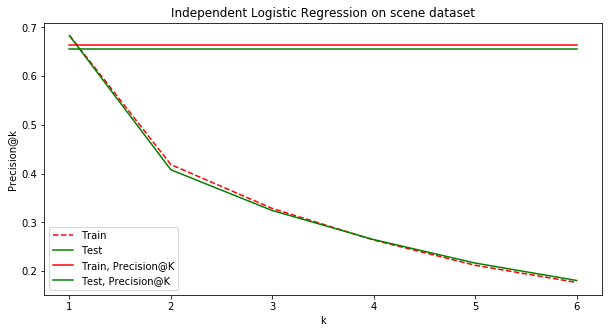

In [13]:
plt.figure(figsize=[10,5])
plt.plot(precisions_train, ls='--', c='r', label='Train')
plt.plot(precisions_test,  ls='-',  c='g', label='Test')
plt.plot([precisionK_train for k in range(nLabels)], ls='-', c='r', label='Train, Precision@K')
plt.plot([precisionK_test  for k in range(nLabels)], ls='-', c='g', label='Test, Precision@K')
plt.xticks(np.arange(nLabels), np.arange(1,nLabels+1))
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.legend(loc='best')
plt.title('Independent Logistic Regression on ' + dataset_name + ' dataset')
plt.savefig(dataset_name + '_lr.svg')